In [2]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from functools import reduce

from scipy.stats import pearsonr, spearmanr, kendalltau

In [3]:

N_PARTITION = 10

# train_parquets = [DATA_DIR / f"train.parquet/partition_id={i}/part-0.parquet" for i in range(N_PARTITION)]
train_parquets = "part-0.parquet"

TEST_PARQUET = 'train-test-0.parquet'

test = pd.read_parquet(TEST_PARQUET)

In [4]:
test['symbol_id'].unique()

array([ 1,  7,  9, 10, 14, 16, 19, 33,  0,  2, 13, 15, 38,  3, 12,  8, 17,
       34, 11, 30], dtype=int8)

In [5]:
test.describe()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
count,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,0.0,0.0,0.0,0.0,0.0,1.944210e+06,...,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06
mean,9.384629e+01,4.240000e+02,1.376638e+01,1.973281e+00,NaN,NaN,NaN,NaN,NaN,-4.463175e-02,...,-9.805073e-02,8.424639e-03,1.076465e-02,2.412764e-03,1.139089e-02,2.185480e-02,3.326982e-03,1.487634e-03,-4.817980e-04,1.078154e-03
std,4.813196e+01,2.450851e+02,1.108778e+01,9.691969e-01,NaN,NaN,NaN,NaN,NaN,9.479579e-01,...,6.398992e-01,9.558780e-01,1.141793e+00,8.442027e-01,1.276044e+00,1.266448e+00,1.225165e+00,8.705768e-01,8.918150e-01,8.737320e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,4.405696e-01,NaN,NaN,NaN,NaN,NaN,-1.176608e+01,...,-3.393299e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00
25%,5.400000e+01,2.120000e+02,7.000000e+00,1.323803e+00,NaN,NaN,NaN,NaN,NaN,-4.756072e-01,...,-3.195696e-01,-2.322211e-01,-2.667868e-01,-1.210319e-01,-4.444537e-01,-5.146699e-01,-2.569897e-01,-3.558709e-01,-3.914038e-01,-2.892584e-01
50%,9.900000e+01,4.240000e+02,1.200000e+01,1.763827e+00,NaN,NaN,NaN,NaN,NaN,-5.818180e-02,...,-2.468792e-01,-3.943805e-03,-2.333469e-02,-1.248489e-03,-1.031224e-02,-1.836913e-02,-4.690550e-03,-9.597129e-03,-2.376243e-02,-3.107830e-04
75%,1.360000e+02,6.360000e+02,1.700000e+01,2.393846e+00,NaN,NaN,NaN,NaN,NaN,3.493771e-01,...,-1.256560e-01,2.309678e-01,2.538152e-01,1.191232e-01,4.292141e-01,5.065366e-01,2.438874e-01,3.360999e-01,3.463979e-01,2.840819e-01
max,1.690000e+02,8.480000e+02,3.800000e+01,6.011999e+00,NaN,NaN,NaN,NaN,NaN,1.532000e+01,...,4.370195e+01,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [6]:
feature_cols = [f'feature_{x:02}' for x in range(79)]
responder_cols = [f'responder_{i}' for i in range(9)]

In [7]:
test

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944205,169,848,19,3.438631,NaN,NaN,NaN,NaN,NaN,-0.028087,...,-0.166964,0.983339,-0.669860,0.272615,-3.676842,-1.221126,1.070584,0.465345,0.207483,0.874975
1944206,169,848,30,0.768528,NaN,NaN,NaN,NaN,NaN,-0.022584,...,-0.352810,0.992615,0.961595,1.089402,0.796034,0.488380,1.846634,-0.088542,-0.008324,-0.153451
1944207,169,848,33,1.354696,NaN,NaN,NaN,NaN,NaN,-0.024804,...,-0.239716,1.701618,0.757672,-5.000000,-3.174266,-1.110790,-3.349107,-0.407801,-0.185842,-0.931004
1944208,169,848,34,1.021797,NaN,NaN,NaN,NaN,NaN,-0.016138,...,-0.442859,-2.036891,-0.064228,1.919665,1.827681,0.872019,3.248694,0.254584,0.090288,0.434726


feature_00         NaN
feature_01         NaN
feature_02         NaN
feature_03         NaN
feature_04         NaN
                ...   
feature_74   -0.002419
feature_75    0.004073
feature_76    0.002745
feature_77   -0.002121
feature_78   -0.003501
Length: 79, dtype: float64


C:\Users\hayde\AppData\Local\Temp\ipykernel_23468\3672491002.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr_with_responder6.index, x=corr_with_responder6.values, palette='coolwarm')


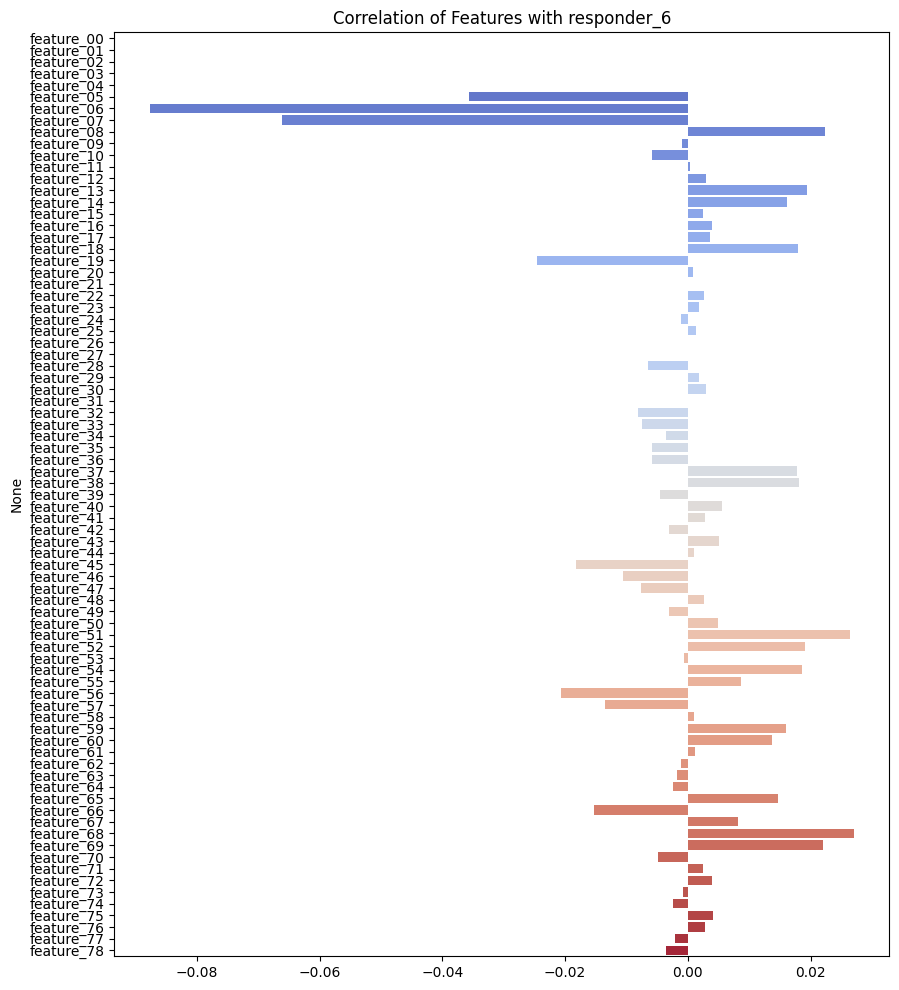

In [8]:
corr_with_responder6 = test[feature_cols].corrwith(test['responder_6'])
print(corr_with_responder6)

plt.figure(figsize=(10, 12))
sns.barplot(y=corr_with_responder6.index, x=corr_with_responder6.values, palette='coolwarm')
plt.title('Correlation of Features with responder_6')
plt.savefig('plot.png')
plt.show()


In [9]:
low_cor_feat = corr_with_responder6[abs(corr_with_responder6) < 0.019].index
test_cleaned = test.drop(columns=low_cor_feat)
test_no_nan = test_cleaned.dropna(axis=1, how='all')
test_no_nan

,date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_13,feature_19,...,feature_69,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,0.851033,0.242971,0.263400,-0.891687,0.003067,-1.707803,...,-0.491157,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,0.676961,0.151984,0.192465,-0.521729,-0.225629,-1.682929,...,-0.592855,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,1.056285,0.187227,0.249901,-0.773050,-0.199404,-2.040234,...,-0.617934,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,1.139366,0.273328,0.306549,-1.262223,3.004091,-0.979447,...,-0.206929,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,0.955200,0.262404,0.344457,-0.613813,-0.030018,-1.586560,...,-0.447704,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944205,169,848,19,3.438631,-0.028087,0.287438,0.118074,-0.644495,0.997164,1.213011,...,1.304514,0.983339,-0.669860,0.272615,-3.676842,-1.221126,1.070584,0.465345,0.207483,0.874975
1944206,169,848,30,0.768528,-0.022584,0.442352,0.140746,-0.571057,0.732816,0.108584,...,-0.185448,0.992615,0.961595,1.089402,0.796034,0.488380,1.846634,-0.088542,-0.008324,-0.153451
1944207,169,848,33,1.354696,-0.024804,0.420692,0.136259,-0.809642,-0.409379,1.392733,...,-0.377317,1.701618,0.757672,-5.000000,-3.174266,-1.110790,-3.349107,-0.407801,-0.185842,-0.931004
1944208,169,848,34,1.021797,-0.016138,0.303561,0.149970,-0.727993,-0.318639,1.642337,...,0.063060,-2.036891,-0.064228,1.919665,1.827681,0.872019,3.248694,0.254584,0.090288,0.434726


In [10]:
test_cleaned.columns

Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
       'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
       'feature_07', 'feature_08', 'feature_13', 'feature_19', 'feature_21',
       'feature_26', 'feature_27', 'feature_31', 'feature_51', 'feature_52',
       'feature_56', 'feature_68', 'feature_69', 'responder_0', 'responder_1',
       'responder_2', 'responder_3', 'responder_4', 'responder_5',
       'responder_6', 'responder_7', 'responder_8'],
      dtype='object')

In [11]:
test_no_nan.groupby(['date_id', 'time_id'])
test_no_nan.set_index(['date_id', 'time_id', 'symbol_id'])


weight  feature_05  feature_06  feature_07  \
date_id time_id symbol_id                                                 
0       0       1          3.889038    0.851033    0.242971    0.263400   
                7          1.370613    0.676961    0.151984    0.192465   
                9          2.285698    1.056285    0.187227    0.249901   
                10         0.690606    1.139366    0.273328    0.306549   
                14         0.440570    0.955200    0.262404    0.344457   
...                             ...         ...         ...         ...   
169     848     19         3.438631   -0.028087    0.287438    0.118074   
                30         0.768528   -0.022584    0.442352    0.140746   
                33         1.354696   -0.024804    0.420692    0.136259   
                34         1.021797   -0.016138    0.303561    0.149970   
                38         1.570022   -0.017634    0.271368    0.128993   

                           feature_08  feature_13  feature_19  feature_51  \
date_id time_id symbol_id                                                   
0       0       1           -0.891687    0.003067   -1.707803    0.204797   
                7           -0.521729   -0.225629   -1.682929    1.172836   
                9           -0.773050   -0.199404   -2.040234    0.535897   
                10          -1.262223    3.004091   -0.979447    2.413415   
                14          -0.613813   -0.030018   -1.586560    1.253902   
...                               ...         ...         ...         ...   
169     848     19          -0.644495    0.997164    1.213011   -1.942191   
                30          -0.571057    0.732816    0.108584    1.210106   
                33          -0.809642   -0.409379    1.392733    1.093185   
                34          -0.727993   -0.318639    1.642337    0.002777   
                38          -0.611178    2.573905    2.087125    0.289495   

                           feature_52  feature_56  ...  feature_69  \
date_id time_id symbol_id                          ...               
0       0       1                 NaN   -2.037683  ...   -0.491157   
                7                 NaN   -1.410017  ...   -0.592855   
                9                 NaN   -2.294170  ...   -0.617934   
                10                NaN   -0.810125  ...   -0.206929   
                14                NaN   -0.771732  ...   -0.447704   
...                               ...         ...  ...         ...   
169     848     19           0.445592   -0.199131  ...    1.304514   
                30           0.012775    0.588312  ...   -0.185448   
                33           1.355752    1.018626  ...   -0.377317   
                34           0.034642    1.401886  ...    0.063060   
                38          -0.102130    0.661158  ...    0.248291   

                           responder_0  responder_1  responder_2  responder_3  \
date_id time_id symbol_id                                                       
0       0       1             0.738489    -0.069556     1.380875     2.005353   
                7             2.965889     1.190077    -0.523998     3.849921   
                9            -0.864488    -0.280303    -0.326697     0.375781   
                10            0.408499     0.223992     2.294888     1.097444   
                14           -0.373387    -0.502764    -0.348021    -3.928148   
...                                ...          ...          ...          ...   
169     848     19            0.983339    -0.669860     0.272615    -3.676842   
                30            0.992615     0.961595     1.089402     0.796034   
                33            1.701618     0.757672    -5.000000    -3.174266   
                34           -2.036891    -0.064228     1.919665     1.827681   
                38            0.323230     0.018376    -3.457667    -0.305218   

                           responder_4  responder_5  responder_6  responder_7  \
date_

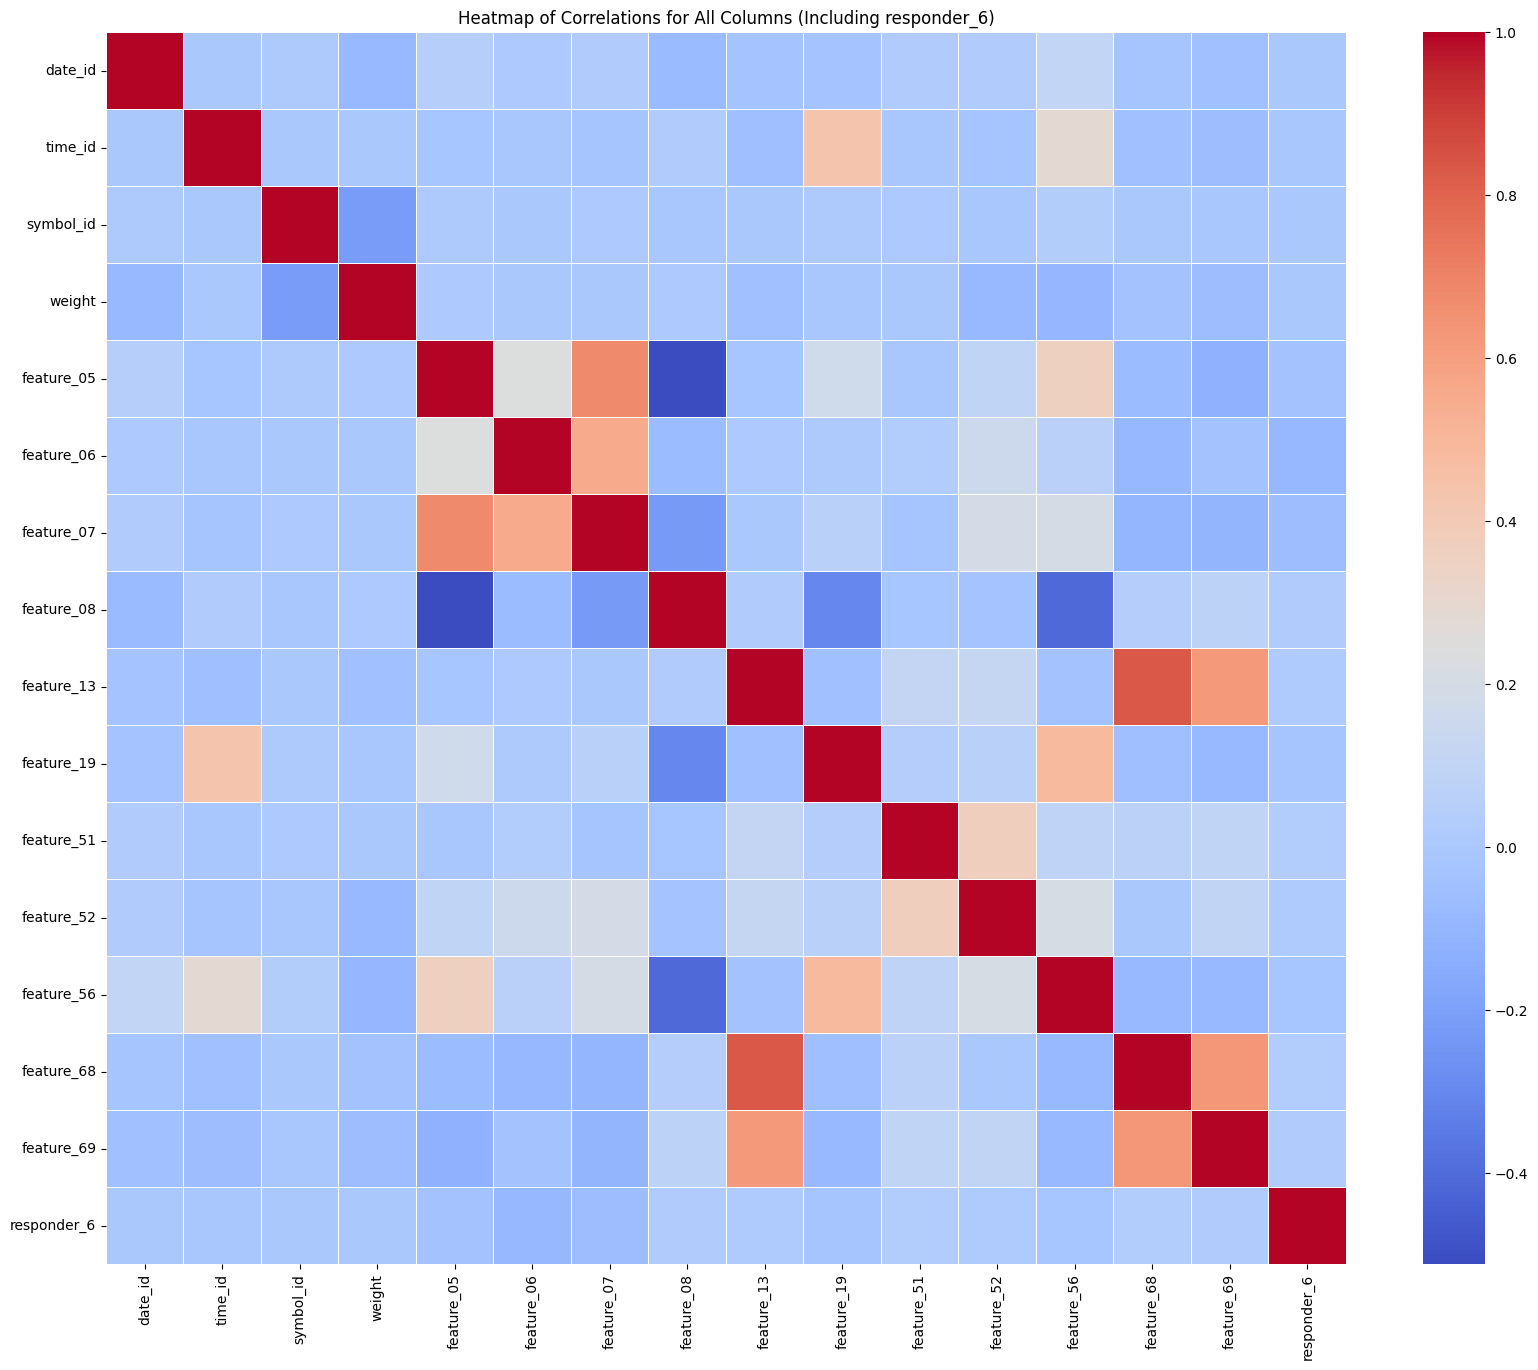

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop all responder columns except responder_6
data = test_no_nan.drop(columns=['responder_0', 'responder_1', 'responder_2', 'responder_3', 
                        'responder_4', 'responder_5', 'responder_7', 'responder_8'])

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the dataset correlations
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns (Including responder_6)')
plt.show()

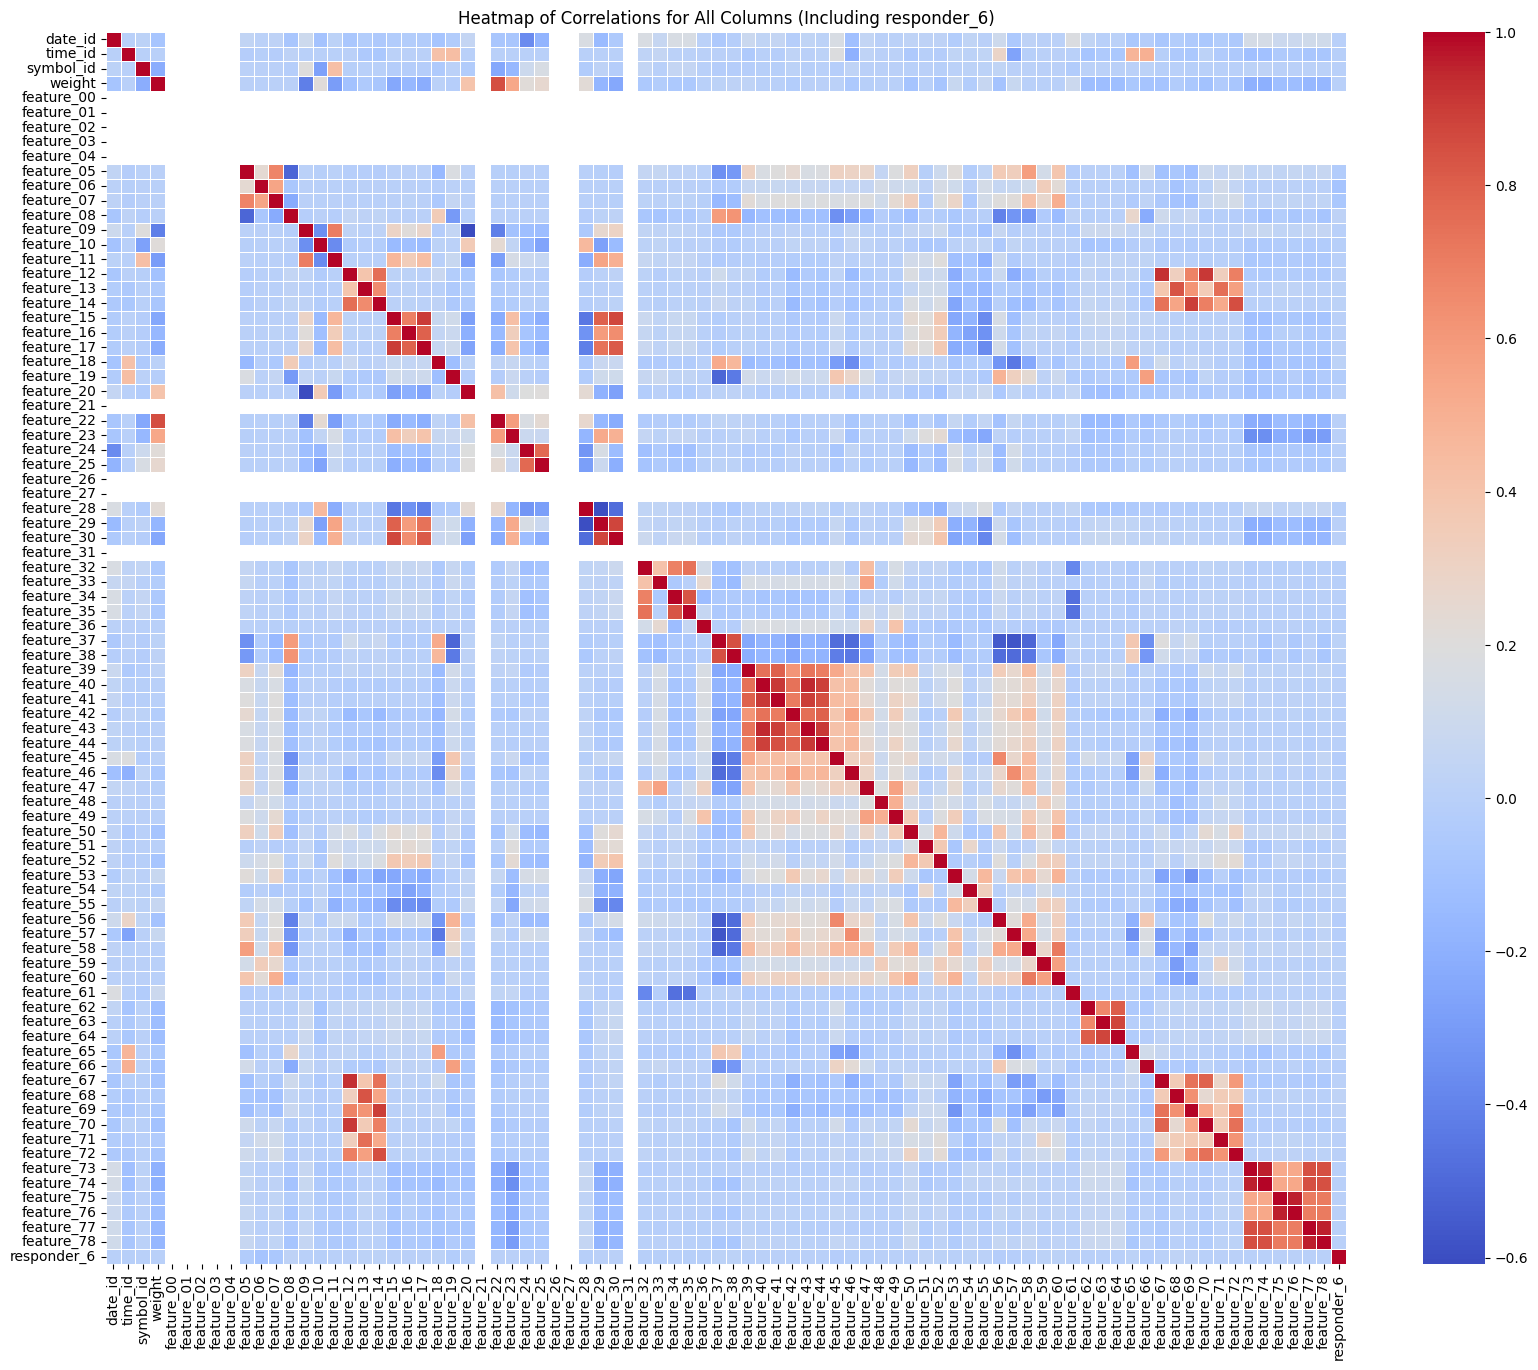

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop all responder columns except responder_6
data_all = test.drop(columns=['responder_0', 'responder_1', 'responder_2', 'responder_3', 
                        'responder_4', 'responder_5', 'responder_7', 'responder_8'])

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the dataset correlations
sns.heatmap(data_all.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns (Including responder_6)')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
data.columns

Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_05', 'feature_06',
       'feature_07', 'feature_08', 'feature_13', 'feature_19', 'feature_51',
       'feature_52', 'feature_56', 'feature_68', 'feature_69', 'responder_6'],
      dtype='object')

In [17]:
data.columns

X = data.drop(columns=['weight', 'responder_6'])
y = data['responder_6']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=10, random_state=42,max_depth=5)

rf.fit(X_train,y_train)


RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

In [18]:
y_pred = rf.predict(X_test )

r2 = r2_score(y_test, y_pred)
r2

0.012376167408617134